# Performance Comparison: vindex vs. fast_vindex

In [14]:
import time

import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

from fast_vindex import patched_vindex
from fast_vindex.utils import generate_fancy_indexes

In [5]:
shape = (5_000, 5_000, 5_000)
chunks = (500, 500, 500)
x = da.random.random(shape, chunks=chunks) 
x 

dask.array<random_sample, shape=(5000, 5000, 5000), dtype=float64, chunksize=(500, 500, 500), chunktype=numpy.ndarray>

In [6]:
N = 19
n_obs = n_obs = [2**i for i in range(N)]
margin = 10
methods = ['vindex', 'fast_vindex']

In [7]:
%%time
data = []
for method in methods:
    for n in n_obs:
        indexes = generate_fancy_indexes(x, n=n, margin=margin)
        
        if method == 'fast_vindex':
            start = time.time()
            with patched_vindex():
                x.vindex[indexes]
            end = time.time()
            data.append(dict(n=n, method=method, margin=margin, run_time=end-start))
        else:
            if n > 512:
                pass
            else:
                start = time.time()
                x.vindex[indexes]
                end = time.time()
                data.append(dict(n=n, method=method, margin=margin, run_time=end-start))
        

CPU times: user 1min 17s, sys: 4.44 s, total: 1min 22s
Wall time: 1min 21s


In [8]:
df = pd.DataFrame(data)
df = df.groupby(['n', 'method', 'margin'])['run_time'].describe()[['50%']].reset_index()

In [9]:
df.head()

,n,method,margin,50%
0,1,fast_vindex,10,0.001056
1,1,vindex,10,0.030896
2,2,fast_vindex,10,0.000809
3,2,vindex,10,0.057474
4,4,fast_vindex,10,0.000999


Slope y: 0.037275884678863926
Slope y: 8.335392103299091e-05


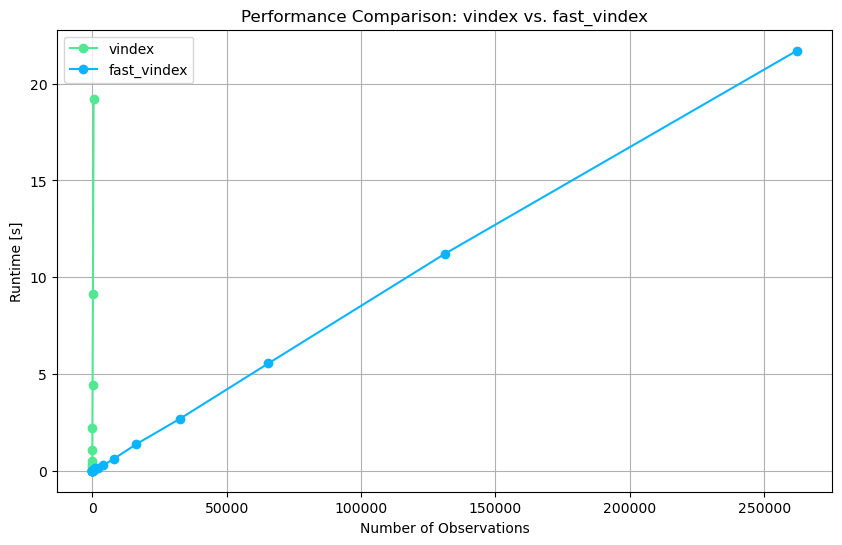

In [22]:
plt.figure(figsize=(10, 6))
colors = {'vindex': "#50e991", 'fast_vindex': "#0bb4ff"}
slopes = {}
for idx, method in enumerate(methods):
    values = df[df['method'] == method].sort_values(by='n')
    x_val = values['n']
    y_val = values['50%']
    slope_y, intercept_y, r_value, p_value, std_err = linregress(x_val, y_val)
    slopes[method] = slope_y
    print(f"Slope y: {slope_y}")
    plt.plot(x_val, y_val, marker='o', linestyle='-', color=colors[method], label=method)
plt.title('Performance Comparison: vindex vs. fast_vindex')
plt.xlabel('Number of Observations')
plt.ylabel('Runtime [s]')
#plt.xscale('log', base=2)
plt.legend()
plt.grid(True)
plt.savefig('../_static/performance_comparison_vindex_vs_fast_vindex_update.png', format='png', dpi=300)

In [ ]:
On calcul ensuite le coefficient 

In [18]:
slopes

{'vindex': np.float64(0.037275884678863926),
 'fast_vindex': np.float64(8.335392103299091e-05)}

In [21]:
slopes['vindex'] / slopes['fast_vindex']

np.float64(447.2001342817501)